# 4. Baseline CNN Model

This notebook builds a simple baseline CNN from scratch, trains it with class-weighted loss, and saves the best model for comparison with transfer learning approaches.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from tqdm import tqdm
import os
from config import *

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("="*60)
print("BASELINE CNN ARCHITECTURE")
print("="*60)

class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize model
model = BaselineCNN(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model Architecture:")
print(f"  • Conv Block 1: 3 → 32 channels")
print(f"  • Conv Block 2: 32 → 64 channels")
print(f"  • Conv Block 3: 64 → 128 channels")
print(f"  • Conv Block 4: 128 → 256 channels")
print(f"  • FC Layers: 50,176 → 512 → {NUM_CLASSES}")

print(f"\n✓ Model Parameters:")
print(f"  • Total parameters: {total_params:,}")
print(f"  • Trainable parameters: {trainable_params:,}")

print(f"\n✓ Model created and moved to {DEVICE}")

BASELINE CNN ARCHITECTURE

✓ Model Architecture:
  • Conv Block 1: 3 → 32 channels
  • Conv Block 2: 32 → 64 channels
  • Conv Block 3: 64 → 128 channels
  • Conv Block 4: 128 → 256 channels
  • FC Layers: 50,176 → 512 → 2

✓ Model Parameters:
  • Total parameters: 26,081,026
  • Trainable parameters: 26,081,026

✓ Model created and moved to cpu


## Loss Function and Optimizer Setup

Configure weighted cross-entropy loss to handle class imbalance, and set up Adam optimizer with learning rate scheduler.

In [2]:
print("="*60)
print("LOSS FUNCTION & OPTIMIZER SETUP")
print("="*60)

# Load class weights
class_weights = torch.load('class_weights.pt')
class_weights = class_weights.to(DEVICE)

print(f"\n✓ Class weights loaded:")
print(f"  • Normal (minority): {class_weights[0]:.4f}")
print(f"  • Pneumonia (majority): {class_weights[1]:.4f}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

print(f"\n✓ Loss Function: Weighted CrossEntropyLoss")
print(f"✓ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✓ Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

# Create directory for saving models
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"\n✓ Model save directory: {MODEL_SAVE_DIR}/")

LOSS FUNCTION & OPTIMIZER SETUP

✓ Class weights loaded:
  • Normal (minority): 1.9448
  • Pneumonia (majority): 0.6730


C:\Users\steve\AppData\Local\Temp\ipykernel_20148\2978875632.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load('class_weights.pt')



✓ Loss Function: Weighted CrossEntropyLoss
✓ Optimizer: Adam (lr=0.001)
✓ Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

✓ Model save directory: models/


C:\Users\steve\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training and Validation Functions

Define training and validation functions with progress tracking and metrics computation.

In [3]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("="*60)
print("TRAINING FUNCTIONS DEFINED")
print("="*60)
print("\n✓ train_one_epoch() - Trains model for one epoch")
print("✓ validate() - Evaluates model on validation set")
print("\n✓ Functions ready for training loop")

TRAINING FUNCTIONS DEFINED

✓ train_one_epoch() - Trains model for one epoch
✓ validate() - Evaluates model on validation set

✓ Functions ready for training loop


## Training Loop with Early Stopping

Train the baseline CNN model with early stopping and save the best model based on validation loss.

In [5]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Recreate transforms
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Custom Dataset class
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_path = os.path.join(root_dir, split, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpeg', '.jpg', '.png')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

# Recreate datasets and dataloaders
train_dataset = ChestXrayDataset(DATASET_PATH, split='train', transform=train_transform)
val_dataset = ChestXrayDataset(DATASET_PATH, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("="*60)
print("TRAINING BASELINE CNN")
print("="*60)

best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"\nTraining for {NUM_EPOCHS} epochs...")
print(f"Early stopping patience: {PATIENCE} epochs\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, f'{MODEL_SAVE_DIR}/baseline_cnn_best.pth')
        print(f"  ✓ Best model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
        break
    
    print()

print("="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"\n✓ Best validation loss: {best_val_loss:.4f}")
print(f"✓ Best model saved to: {MODEL_SAVE_DIR}/baseline_cnn_best.pth")

C:\Users\steve\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


TRAINING BASELINE CNN

Training for 10 epochs...
Early stopping patience: 5 epochs

Epoch [1/10]


  Train Loss: 1.3371, Train Acc: 83.63%
  Val Loss: 0.2659, Val Acc: 82.98%
  ✓ Best model saved! (Val Loss: 0.2659)

Epoch [2/10]


  Train Loss: 0.2177, Train Acc: 91.53%
  Val Loss: 0.3392, Val Acc: 78.72%
  No improvement (1/5)

Epoch [3/10]


  Train Loss: 0.1847, Train Acc: 92.83%
  Val Loss: 0.2685, Val Acc: 87.23%
  No improvement (2/5)

Epoch [4/10]


  Train Loss: 0.1890, Train Acc: 93.21%
  Val Loss: 0.3270, Val Acc: 80.85%
  No improvement (3/5)

Epoch [5/10]


  Train Loss: 0.1689, Train Acc: 93.48%
  Val Loss: 0.3896, Val Acc: 82.98%
  No improvement (4/5)

Epoch [6/10]


  Train Loss: 0.1322, Train Acc: 94.69%
  Val Loss: 0.2361, Val Acc: 85.11%
  ✓ Best model saved! (Val Loss: 0.2361)

Epoch [7/10]


  Train Loss: 0.1299, Train Acc: 95.38%
  Val Loss: 0.6707, Val Acc: 74.47%
  No improvement (1/5)

Epoch [8/10]


  Train Loss: 0.1244, Train Acc: 95.05%
  Val Loss: 0.3292, Val Acc: 82.98%
  No improvement (2/5)

Epoch [9/10]


  Train Loss: 0.1178, Train Acc: 95.55%
  Val Loss: 0.4470, Val Acc: 78.72%
  No improvement (3/5)

Epoch [10/10]


  Train Loss: 0.1208, Train Acc: 95.67%
  Val Loss: 0.4782, Val Acc: 74.47%
  No improvement (4/5)

TRAINING COMPLETE

✓ Best validation loss: 0.2361
✓ Best model saved to: models/baseline_cnn_best.pth


## Training History Visualization

Plot training and validation loss/accuracy curves to analyze model performance.

TRAINING HISTORY


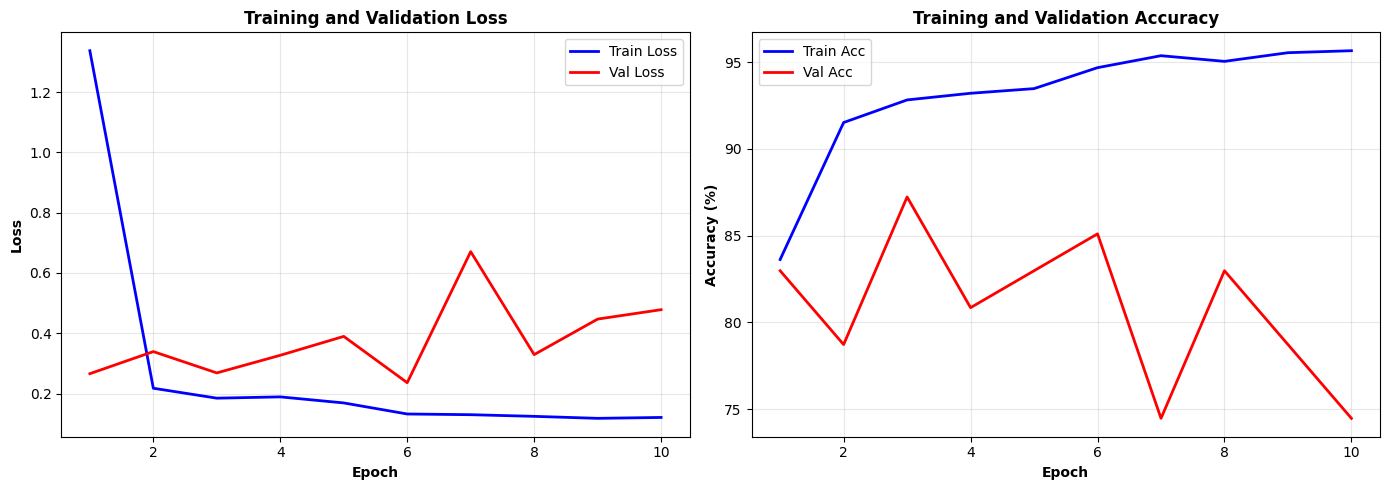


✓ Training history plot saved as 'baseline_cnn_training_history.png'

TRAINING SUMMARY

Final Training Accuracy: 95.67%
Final Validation Accuracy: 74.47%
Best Validation Loss: 0.2361
Best Validation Accuracy: 87.23%

NOTEBOOK 4 COMPLETE - model_baseline_cnn.ipynb
Next: Create 'model_densenet121.ipynb' for transfer learning


In [6]:
import matplotlib.pyplot as plt

print("="*60)
print("TRAINING HISTORY")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
epochs_range = range(1, len(train_losses) + 1)
axes[0].plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(epochs_range, train_accs, 'b-', label='Train Acc', linewidth=2)
axes[1].plot(epochs_range, val_accs, 'r-', label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Training history plot saved as 'baseline_cnn_training_history.png'")

# Print summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nFinal Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {max(val_accs):.2f}%")

print("\n" + "="*60)
print("NOTEBOOK 4 COMPLETE - model_baseline_cnn.ipynb")
print("="*60)
print("Next: Create 'model_densenet121.ipynb' for transfer learning")